In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:

df = pd.read_csv('AirQualityUCI.csv', sep=';',na_values=-200, decimal=',')


df.drop(['Unnamed: 15','Unnamed: 16','NMHC(GT)'], axis = 1, inplace = True)

df.Time = df.Time.str.replace('.',':')
df.Date = df["Date"]+' '+df['Time']
df.Date = pd.to_datetime(df.Date,dayfirst=True, infer_datetime_format=True)
df = df.set_index('Date')
df.drop(['Time'], axis = 1, inplace = True)



<ipython-input-38-92f797850fc3>:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.Date = pd.to_datetime(df.Date,dayfirst=True, infer_datetime_format=True)


1. Two last columns are all NaNs (`Unnamed: 15`, `Unnamed: 16`);
2. One column contains only 1% of non-missing values (`NMHC(GT)`);
3. `Date` and `Time` columns can be set as an index (pd.DateTimeIndex).


Now let's see if there were some 'bad days', that contain mostly missing values:

In [ ]:
print('Maximum number of missing values = number of columns in df = {}'.format(len(df.columns)))

Maximum number of missing values = number of columns in df = 12


Remove rows that have more than 10 missing values:

In [ ]:
bad_rows = df[df.shape[1] - df.count(axis=1) > 10].index
df.drop(bad_rows, axis = 0, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9313 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7661 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   C6H6(GT)       8991 non-null   float64
 3   PT08.S2(NMHC)  8991 non-null   float64
 4   NOx(GT)        7718 non-null   float64
 5   PT08.S3(NOx)   8991 non-null   float64
 6   NO2(GT)        7715 non-null   float64
 7   PT08.S4(NO2)   8991 non-null   float64
 8   PT08.S5(O3)    8991 non-null   float64
 9   T              8991 non-null   float64
 10  RH             8991 non-null   float64
 11  AH             8991 non-null   float64
dtypes: float64(12)
memory usage: 945.9 KB


Removing missing values in target variable

In [ ]:
df.drop(df[df['C6H6(GT)'].isnull()].index, axis = 0, inplace = True)

In [ ]:
df.shape

(8991, 12)

We have time-dependent data set. In order to perform validation we need to predict future by using past:  
so first 8000 rows will be __train__ and last ~2000 will be __test__

In [ ]:
df = df.sort_index()
train, test = df.iloc[:8000,:], df.iloc[8000:,:]

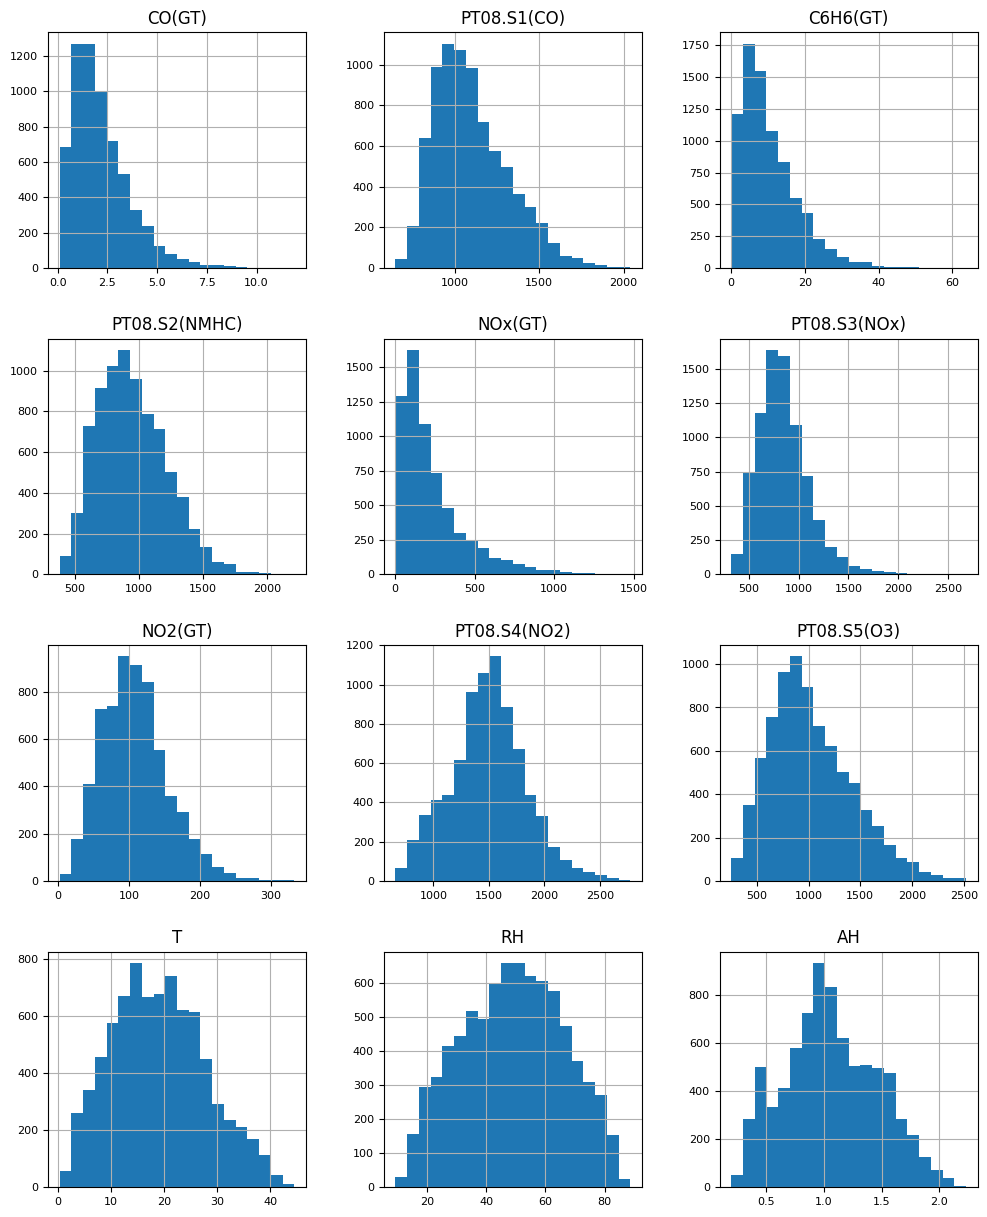

In [ ]:
train.hist(figsize=(12, 15), bins=20, xlabelsize=8, ylabelsize=8);

We see, that some of variables' distributions are skewed, so to fill NAs with _medians_ would be the best strategy.
We'll save medians in train df for future use in test df:

In [ ]:

to_fill = {}
for i in train.columns:
    to_fill[i] = np.nanmedian(train[i])
train = train.fillna(value = to_fill)
train.count() / train.shape[0]

,0
CO(GT),1.0
PT08.S1(CO),1.0
C6H6(GT),1.0
PT08.S2(NMHC),1.0
NOx(GT),1.0
PT08.S3(NOx),1.0
NO2(GT),1.0
PT08.S4(NO2),1.0
PT08.S5(O3),1.0
T,1.0


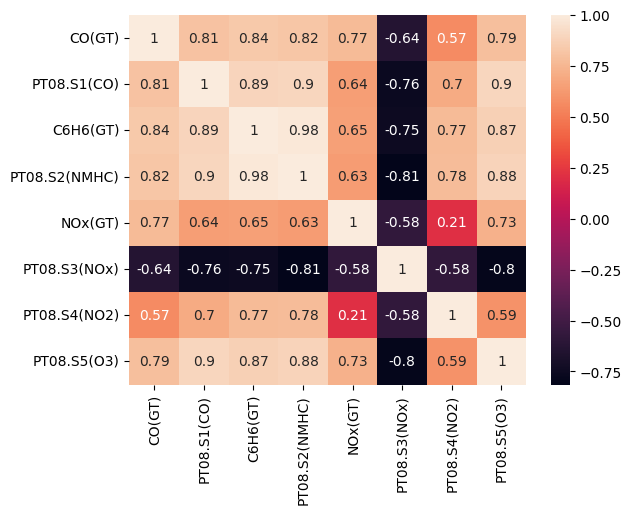

In [ ]:
corr = train.corr()
condition = np.absolute(corr['C6H6(GT)']) > 0.6
top_corr = corr.loc[condition,condition]
data_top_corr = train.loc[:,top_corr.columns]
sns.heatmap(top_corr, annot=True);

In [ ]:
top_corr_features = list(data_top_corr.columns)
top_corr_features.remove('C6H6(GT)')

In [ ]:
train_X, train_y = train.drop('C6H6(GT)', axis = 1), train['C6H6(GT)']
test_X, test_y = train.drop('C6H6(GT)', axis = 1), train['C6H6(GT)']

In [ ]:
train_selected_X = train_X[top_corr_features]
test_selected_X = test_X[top_corr_features]

Since there are no dramatic outliers in data, the choice of best scaler relies to preserving relationship between variables which are highly correlated with target in dataset.  
To choose the best scaler let's draw a pairplot between _'PT08.S2(NMHC)'_ variable and _'C6H6(GT)'_(target)  
Two scalers to compare: _MinMax_scaler()_ and _Robust_scaler()_
Minmax scaler is more simple, susceptible to outliers and saves distribution of values.  
Robust scaler uses complex algorithms and outlier-prone.

In [ ]:

train_X_robust = pd.DataFrame(RobustScaler().fit_transform(train_selected_X), columns = train_selected_X.columns)
train_X_minmax = pd.DataFrame(MinMaxScaler().fit_transform(train_selected_X), columns = train_selected_X.columns)

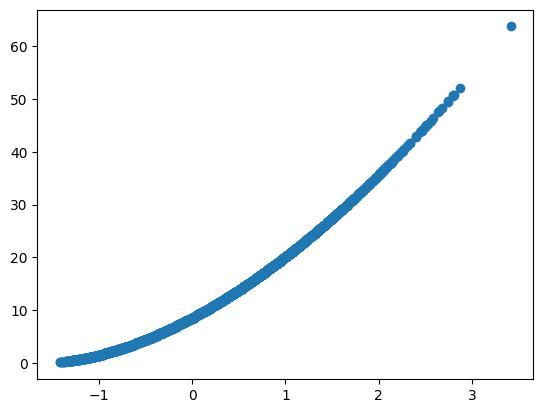

In [ ]:
plt.scatter(x = train_X_robust['PT08.S2(NMHC)'], y = train_y);

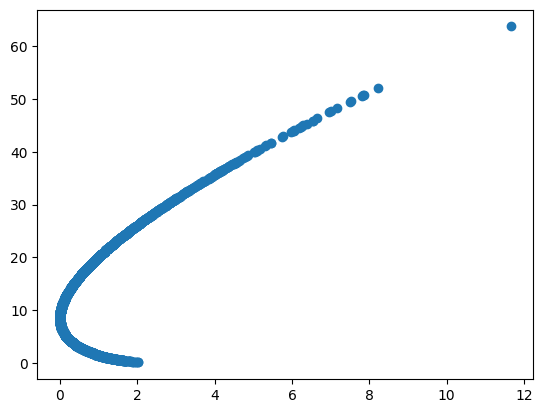

In [ ]:
plt.scatter(x = (train_X_robust['PT08.S2(NMHC)'])**2, y = train_y);

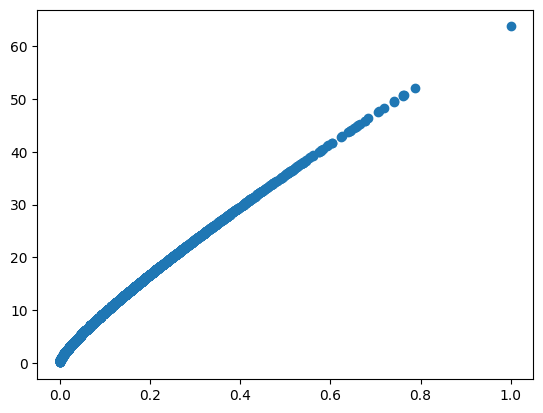

In [ ]:
plt.scatter(x = (train_X_minmax['PT08.S2(NMHC)'])**2, y = train_y);

In [ ]:

def train_and_evaluate_model(train,preprocessed_target,test,test_preprocessed_target,model, test_size=0.2, random_state=42):
    train_X, train_y = train,preprocessed_target
    test_X, test_y = test,test_preprocessed_target

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(train_X)
    X_test_scaled = scaler.transform(test_X)

    model.fit(X_train_scaled, train_y)

    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)

    return [y_pred, test_y,X_test_scaled,X_train_scaled,
            pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(train_y, y_train_pred))],
        'train_R2': [r2_score(train_y, y_train_pred)],
        'val_RMSE': [np.sqrt(mean_squared_error(test_y, y_pred))],
        'val_R2': [r2_score(test_y, y_pred)],
        'train_MAE': [mean_absolute_error(train_y, y_train_pred)],
        'val_MAE': [mean_squared_error(test_y, y_pred)]
    })]

To check quality of a model, I've chosen _RMSE_ as a general metric because it uses the same scale as initial data (not squared units) and _MAE_ to compare results and $R^2$ as a statistical metric because the number of features in data is not enormously high.

Clearly MinMax scaler wins.  

In [ ]:

tree_reg = DecisionTreeRegressor(max_depth=2)


y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,tree_reg)


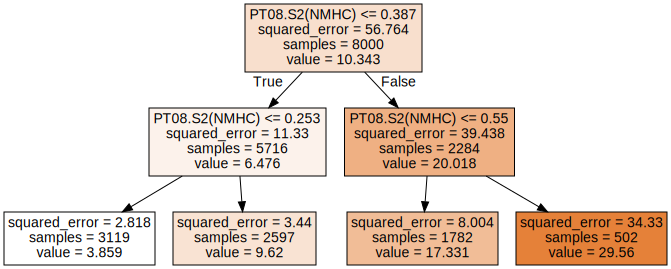

In [ ]:

labels = train_selected_X.columns

graph = Source(tree.export_graphviz(tree_reg ,feature_names = labels, max_depth = 2, filled = True))
display(SVG(graph.pipe(format='svg')))

The root node splits the dataset into two subsets based on whether PT08.S2(NMHC) is less than or equal to 0.387.

PT08.S2(NMHC) is the most important feature used for splitting at every decision point. This feature explains most of the variance in the target variable.
The leaf nodes represent the final predictions or averages of the target variable for subsets.
The leaf node with squared error = 34.33 indicates a region of high variance in the data where the model struggles to make accurate predictions.

The visualization helps understand:

Most important feature: PT08.S2(NMHC) drives the splits.
How decisions are made: Values of this feature determine the predicted output.
Model performance: Low variance regions perform better, while high variance areas (PT08.S2(NMHC) > 0.55) may require further analysis or additional data.


In [ ]:
print(metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    2.480393  0.891616  2.480393  0.891616   1.894837  6.152351


Data is time-dependent, thus we have to use _TimeSeriesSplit_ for cross-validation:

In [ ]:

tscv = TimeSeriesSplit(n_splits=5)


Hyperparamteters tuning

In [ ]:
param_grid= {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


gs = GridSearchCV(
        DecisionTreeRegressor(),
        param_grid,
        n_jobs=-1,
         scoring=['neg_mean_squared_error', 'r2'],
         refit='neg_mean_squared_error',
         cv=tscv
)

In [ ]:
gs.fit(X_train_scaled, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,gs.best_estimator_)

In [ ]:
print(metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.093269  0.999847  0.093269  0.999847   0.005925  0.008699


RMSE is much lower than for DecisionTreeRegressor

Hyperparameter values performance

In [ ]:

results = pd.DataFrame(gs.cv_results_)

results.columns


results = results[['param_max_depth', 'param_min_samples_leaf','param_min_samples_split',
                   'mean_test_neg_mean_squared_error', 'mean_test_r2']]

results.rename(columns={
    'param_max_depth': 'max_depth',
    'param_min_samples_leaf': 'min_samples_leaf',
    'param_min_samples_split': 'min_samples_split',
    'mean_test_neg_mean_squared_error': 'neg_MSE',
    'mean_test_r2': 'R2'
}, inplace=True)

results['MSE'] = -results['neg_MSE']

print(results.head())


   max_depth  min_samples_leaf  min_samples_split   neg_MSE        R2  \
0         10                 1                  2 -0.115862  0.998566   
1         10                 1                  5 -0.118341  0.998543   
2         10                 1                 10 -0.129518  0.998364   
3         10                 2                  2 -0.113809  0.998634   
4         10                 2                  5 -0.119736  0.998512   

        MSE  
0  0.115862  
1  0.118341  
2  0.129518  
3  0.113809  
4  0.119736  


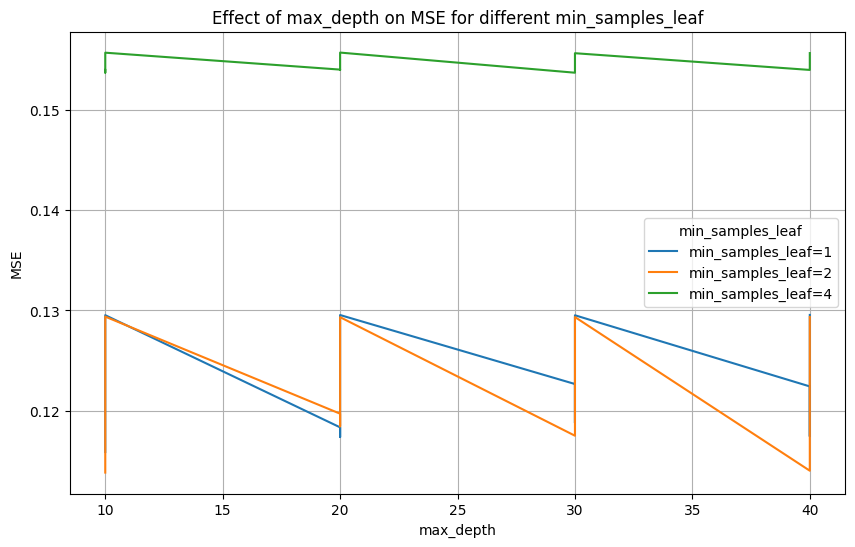

In [ ]:

plt.figure(figsize=(10, 6))

for min_samples_leaf in results['min_samples_leaf'].unique():
    subset = results[results['min_samples_leaf'] == min_samples_leaf]
    plt.plot(subset['max_depth'], subset['MSE'], label=f'min_samples_leaf={min_samples_leaf}')

plt.title('Effect of max_depth on MSE for different min_samples_leaf')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(title='min_samples_leaf')
plt.grid(True)
plt.show()


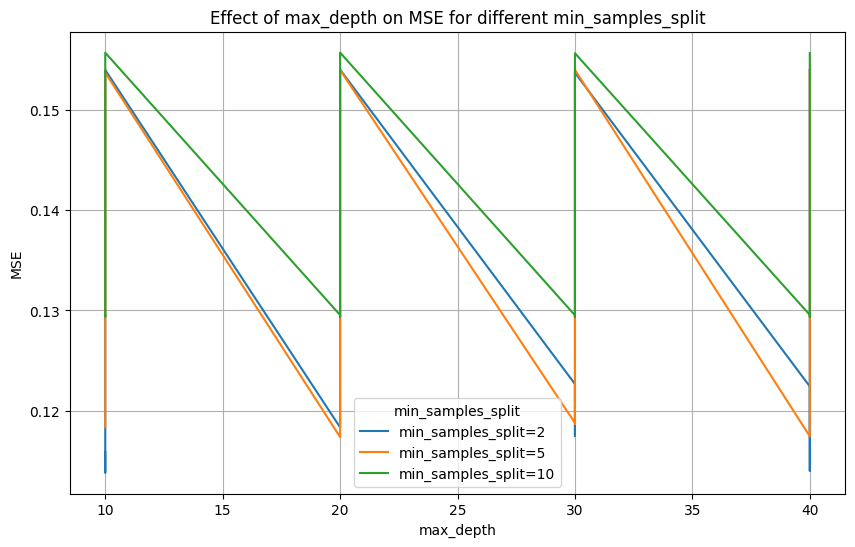

In [ ]:
plt.figure(figsize=(10, 6))

for min_samples_split in results['min_samples_split'].unique():
    subset = results[results['min_samples_split'] == min_samples_split]
    plt.plot(subset['max_depth'], subset['MSE'], label=f'min_samples_split={min_samples_split}')

plt.title('Effect of max_depth on MSE for different min_samples_split')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(title='min_samples_split')
plt.grid(True)
plt.show()


Impact of max_depth:

Limiting the depth of the tree forces it to make fewer splits, which results in a simpler model that may have high bias (underfitting).
Increasing max_depth allows the tree to grow deeper, which can help capture more complex relationships in the data, potentially improving performance. However, very deep trees may lead to overfitting, as the model learns even the noise in the training data, resulting in lower performance on unseen data (higher variance).Need to find balanced value for max_depth.

Impact of min_samples_leaf:

When the minimum number of samples required to be at a leaf node is set very low, the tree can overfit, as it allows nodes to contain only a single data point.
Increasing min_samples_leaf forces the model to group smaller datasets into larger groups at the leaf nodes. This reduces the model's complexity, helping it generalize better by avoiding overfitting.

Impact of min_samples_split:

A smaller value allows the tree to split the nodes with fewer samples, which results in more splits, deeper trees, and potentially more complex models. This can lead to overfitting if the tree becomes too intricate and captures noise in the data.
A larger value restricts the tree from splitting nodes too early, resulting in simpler, shallower trees. While this reduces the risk of overfitting, it may also lead to underfitting if the tree is too simple to model the underlying patterns in the data.


Interaction Between max_depth, min_samples_leaf, and min_samples_split:

If you increase max_depth while keeping min_samples_leaf and min_samples_split small, the model will have a greater chance of overfitting, as it will create deep, complex trees with smaller data points in each leaf. On the other hand, if you increase both min_samples_leaf and min_samples_split, you can restrict the growth of the tree, leading to a simpler, potentially underfitting model.
The best performance is generally observed when max_depth is set to a moderate level, while min_samples_leaf and min_samples_split are chosen to ensure that the tree does not grow too complex.

Feature importance

         Feature  Importance
2  PT08.S2(NMHC)         1.0
0         CO(GT)         0.0
1    PT08.S1(CO)         0.0
3        NOx(GT)         0.0
4   PT08.S3(NOx)         0.0
5   PT08.S4(NO2)         0.0
6    PT08.S5(O3)         0.0


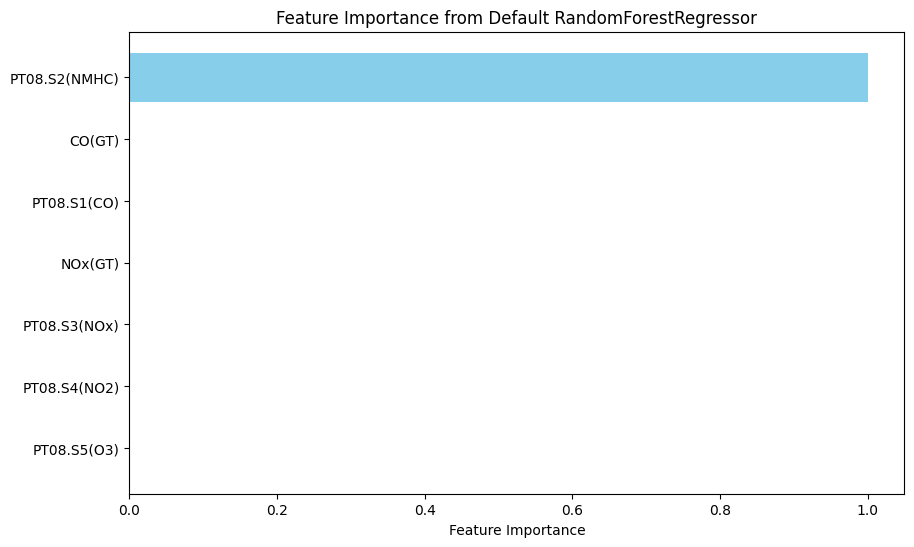

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': train_selected_X.columns,
    'Importance': tree_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Default RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

The most important feature is PT08.S2(NMHC) so  
This is the one with the highest correlation and decision tree model also justifies it, so big coefficient of this feature in model is not due overfitting, but acctually a valid result

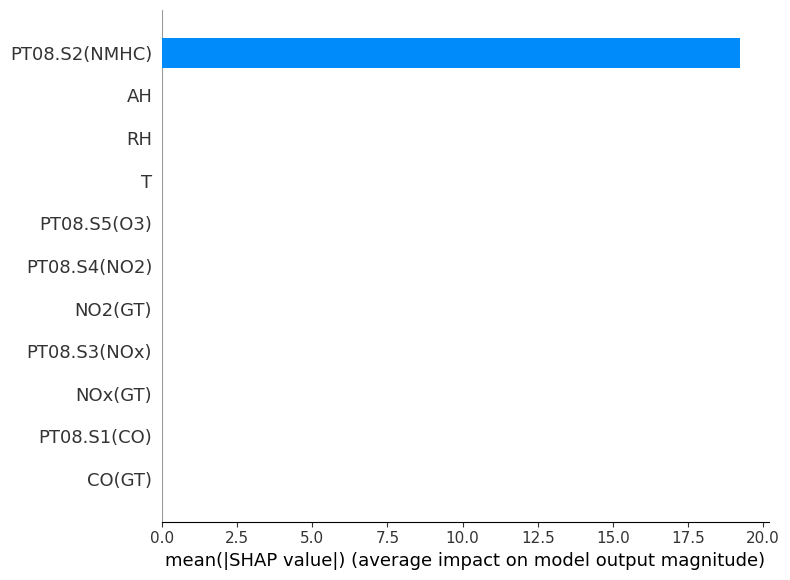

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(tree_reg)
shap_values = explainer.shap_values(test_X)

shap.summary_plot(shap_values, test_X, plot_type="bar")


sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], test_X.iloc[sample_index])


I choose SHAP because his biggest advantage is abilibty to handle interactions between features.A decision tree might split based on one feature, but SHAP will tell you if the presence of other features made the split more important.

It confirms that this is PT08.S2(NMHC)

Random ForestRegressor

In [ ]:

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,rf_regressor)


In [ ]:
print(metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.061255  0.999934  0.061255  0.999934    0.00516  0.003752


In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gs = GridSearchCV(
        RandomForestRegressor(),
        param_grid,
        n_jobs=-1,
         scoring=['neg_mean_squared_error', 'r2'],
         refit='neg_mean_squared_error',
         cv=tscv
)

In [ ]:
gs.fit(X_train_scaled, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,gs.best_estimator_)

In [ ]:
print(metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.060123  0.999936  0.060123  0.999936   0.005113  0.003615


__Result__: RMSE is little lower than for RandomForestRegressor() model

In [ ]:

results = pd.DataFrame(gs.cv_results_)

results.columns

results = results[['param_min_samples_leaf', 'param_min_samples_split','param_n_estimators',
                   'mean_test_neg_mean_squared_error', 'mean_test_r2']]

results.rename(columns={
    'param_min_samples_leaf': 'min_samples_leaf',
    'param_min_samples_split': 'min_samples_split',
    'param_n_estimators': 'n_estimators',
    'mean_test_neg_mean_squared_error': 'neg_MSE',
    'mean_test_r2': 'R2'
}, inplace=True)

results['MSE'] = -results['neg_MSE']

print(results.head())

   min_samples_leaf  min_samples_split  n_estimators   neg_MSE        R2  \
0                 1                  2           100 -0.135675  0.998368   
1                 1                  2           200 -0.134922  0.998372   
2                 1                  2           300 -0.135754  0.998368   
3                 1                  2           500 -0.133025  0.998398   
4                 1                  5           100 -0.134989  0.998367   

        MSE  
0  0.135675  
1  0.134922  
2  0.135754  
3  0.133025  
4  0.134989  


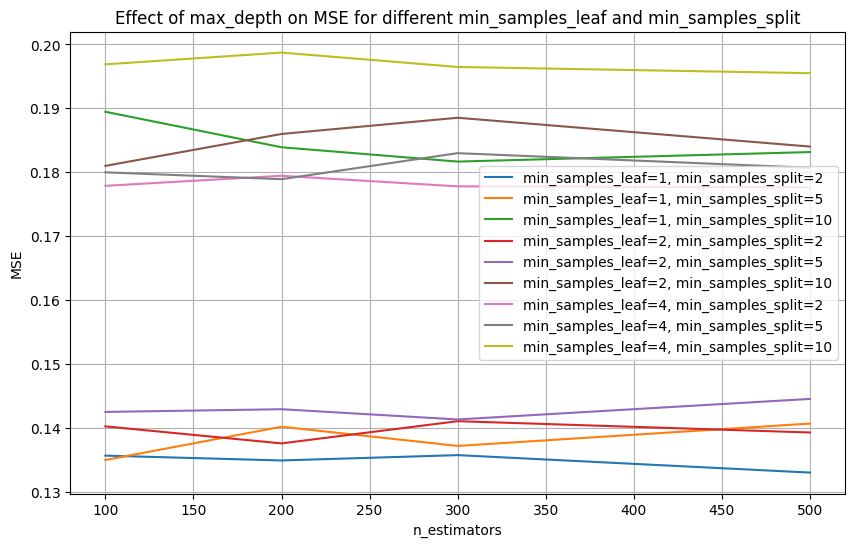

In [ ]:
plt.figure(figsize=(10, 6))

for min_samples_leaf in results['min_samples_leaf'].unique():
    for min_samples_split in results['min_samples_split'].unique():
        subset = results[(results['min_samples_leaf'] == min_samples_leaf) &
                         (results['min_samples_split'] == min_samples_split)]

        plt.plot(subset['n_estimators'], subset['MSE'], label=f'min_samples_leaf={min_samples_leaf}, min_samples_split={min_samples_split}')

plt.title('Effect of max_depth on MSE for different min_samples_leaf and min_samples_split')
plt.xlabel('n_estimators')
plt.ylabel('MSE')

plt.legend()
plt.grid()

plt.show()


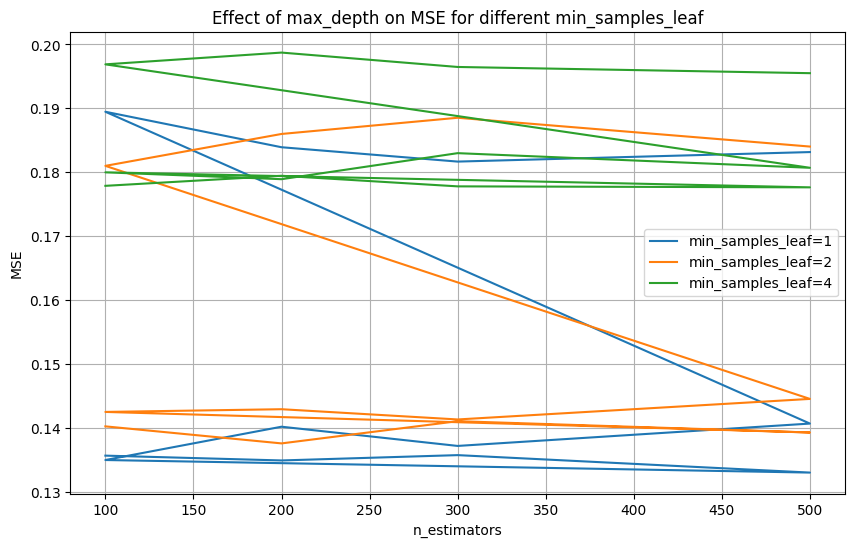

In [ ]:
plt.figure(figsize=(10, 6))

for min_samples_leaf in results['min_samples_leaf'].unique():
    subset = results[results['min_samples_leaf'] == min_samples_leaf]
    plt.plot(subset['n_estimators'], subset['MSE'], label=f'min_samples_leaf={min_samples_leaf}')

plt.title('Effect of max_depth on MSE for different min_samples_leaf')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()



Impact of n_estimators:

A small number of estimators (trees) in the Random Forest means fewer decision trees are used to make predictions. While this reduces the model’s complexity and training time, it can also reduce the model's performance because the decision-making power is limited by the lower number of trees, leading to potentially higher bias.
Increasing the number of trees generally improves the performance of the Random Forest model by reducing variance and improving generalization. More trees provide more diverse decisions, which can enhance the robustness of the model. However, adding too many trees may lead to diminishing returns

Impact of min_samples_split:

A smaller value for min_samples_split allows the tree to make more splits, resulting in deeper trees. This increases the complexity of the model and can lead to overfitting if the tree becomes too intricate, capturing noise in the data.
Larger values for min_samples_split restrict the tree from making splits too early. This results in shallower trees and simpler models. While this reduces the risk of overfitting, it may also cause underfitting if the model becomes too simplistic and fails to capture the data's underlying patterns.


Impact of min_samples_leaf:

A smaller value for min_samples_leaf means the decision tree can have leaf nodes with fewer data points. This can make the model more complex and more likely to overfit, as the tree will have more splits and potentially capture noise from the data.
Increasing min_samples_leaf forces the algorithm to require more data points per leaf, which reduces the model's complexity. This can help the model generalize better and avoid overfitting, but setting this value too high may lead to underfitting, where the model is too simple to capture the underlying patterns in the data.

Interaction Between n_estimators, min_samples_leaf, and min_samples_split:

If min_samples_leaf and min_samples_split are set too low, the model may produce highly complex trees with more splits, which can result in overfitting. In such cases, increasing n_estimators may help by averaging out the predictions from more trees, thus reducing overfitting.
If both min_samples_leaf and min_samples_split are set higher, the trees become simpler, reducing the risk of overfitting. However, if n_estimators is also set too low, the model may underfit because the number of trees might not be sufficient to capture the complexity of the data.
The optimal performance is typically achieved by balancing the depth and complexity of the trees with the number of trees used in the forest. For example, increasing n_estimators while adjusting min_samples_leaf and min_samples_split to prevent overfitting is a good strategy.

         Feature  Importance
2  PT08.S2(NMHC)    0.999695
1    PT08.S1(CO)    0.000184
5   PT08.S4(NO2)    0.000040
4   PT08.S3(NOx)    0.000032
0         CO(GT)    0.000020
3        NOx(GT)    0.000019
6    PT08.S5(O3)    0.000010


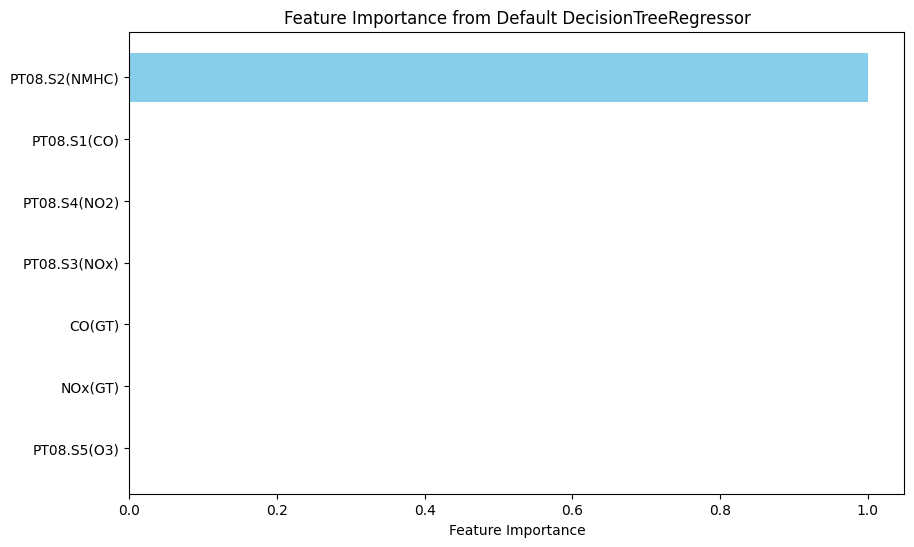

In [ ]:

feature_importance = pd.DataFrame({
    'Feature': train_selected_X.columns,
    'Importance': rf_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Default DecisionTreeRegressor')
plt.gca().invert_yaxis()
plt.show()


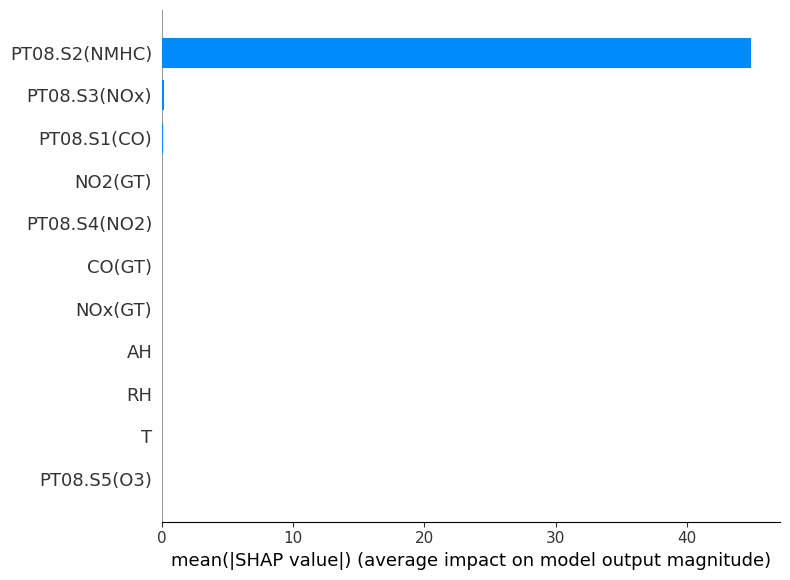

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(test_X)

shap.summary_plot(shap_values, test_X, plot_type="bar")


sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], test_X.iloc[sample_index])


Same situation as in DecisionTreeRegressor()

Bossting Regressor

In [ ]:

xgb = XGBRegressor()

y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,xgb)


In [ ]:
print(metrics)


   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.037221  0.999976  0.037221  0.999976    0.02796  0.001385


In [ ]:
param_grid = {
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0, 0.1, 1]
}


gs = GridSearchCV(
        XGBRegressor(),
        param_grid,
        n_jobs=-1,
         scoring=['neg_mean_squared_error', 'r2'],
         refit='neg_mean_squared_error',
         cv=tscv
)

In [ ]:
gs.fit(X_train_scaled, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 10], 'min_child_weight': [1, 3, 5],
                         'reg_lambda': [0, 0.1, 1]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
y_pred, y_test,X_test_scaled,X_train,X_train_scaled, metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,gs.best_estimator_)

In [ ]:
print(metrics)

   train_RMSE  train_R2  val_RMSE  val_R2  train_MAE   val_MAE
0    0.001779       1.0  0.001779     1.0   0.001235  0.000003


__Result__: RMSE is lower than for XGBRegressor() model

In [ ]:

results = pd.DataFrame(gs.cv_results_)

results.columns


results = results[['param_max_depth', 'param_min_child_weight','param_reg_lambda',
                   'mean_test_neg_mean_squared_error', 'mean_test_r2']]

results.rename(columns={
    'param_max_depth': 'max_depth',
    'param_min_child_weight': 'min_child_weight',
    'param_reg_lambda': 'reg_lambda',
    'mean_test_neg_mean_squared_error': 'neg_MSE',
    'mean_test_r2': 'R2'
}, inplace=True)

results['MSE'] = -results['neg_MSE']

print(results.head())

   max_depth  min_child_weight  reg_lambda   neg_MSE        R2       MSE
0          3                 1         0.0 -0.286383  0.996375  0.286383
1          3                 1         0.1 -0.291145  0.996323  0.291145
2          3                 1         1.0 -0.307500  0.996137  0.307500
3          3                 3         0.0 -0.287469  0.996172  0.287469
4          3                 3         0.1 -0.296888  0.996081  0.296888


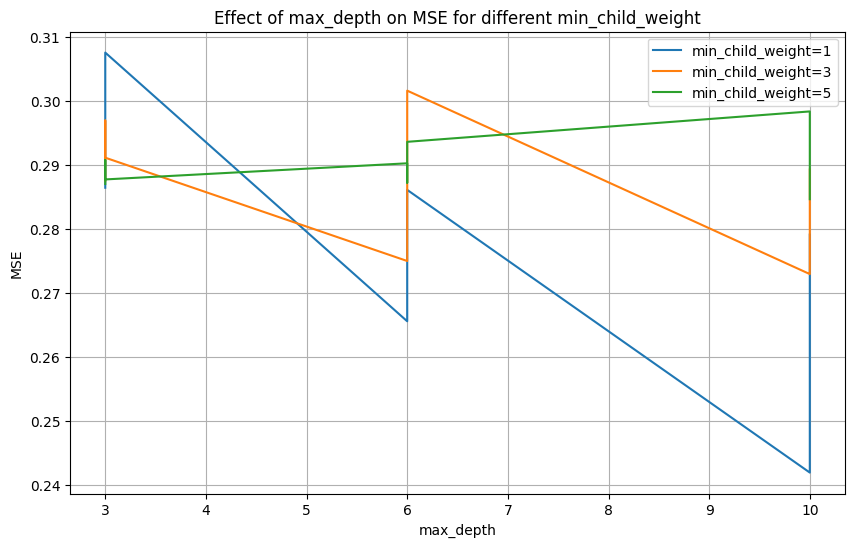

In [ ]:
plt.figure(figsize=(10, 6))

for weight in results['min_child_weight'].unique():
    subset = results[results['min_child_weight'] == weight]
    plt.plot(subset['max_depth'], subset['MSE'], label=f'min_child_weight={weight}')

plt.title('Effect of max_depth on MSE for different min_child_weight')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()


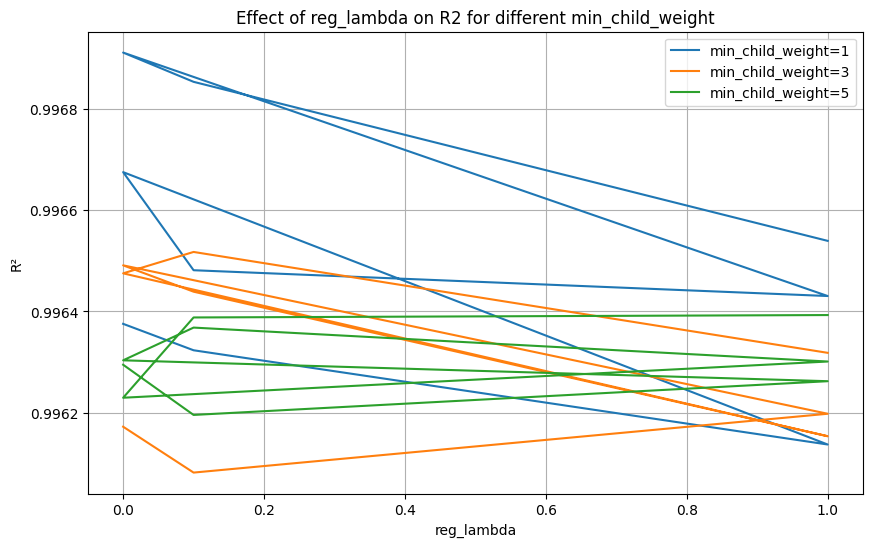

In [ ]:

plt.figure(figsize=(10, 6))

for weight in results['min_child_weight'].unique():
    subset = results[results['min_child_weight'] == weight]
    plt.plot(subset['reg_lambda'], subset['R2'], label=f'min_child_weight={weight}')

plt.title('Effect of reg_lambda on R2 for different min_child_weight')
plt.xlabel('reg_lambda')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()


Impact of max_depth:

Limiting the depth of the tree (via max_depth) simplifies the model by restricting its ability to grow, which can prevent overfitting.
Increasing max_depth allows the model to grow deeper, capturing more complex relationships. However, excessively large max_depth can lead to overfitting, as the model may also learn noise in the training data.
A balance must be found: setting max_depth to a moderate value often provides the best results, achieving a good tradeoff between bias and variance.

Impact of min_child_weight:

min_child_weight controls the minimum sum of instance weights (or sample counts) required to create a new leaf node.
Lower values of min_child_weight allow the model to grow more complex trees by splitting nodes even when only a small number of instances are present.
Higher values of min_child_weight make the model more conservative, as it requires larger sample weights to perform a split.

Impact of reg_lambda:

reg_lambda (L2 regularization) adds a penalty to the model for large leaf weights, reducing the risk of overfitting by controlling the size of leaf weights.
A small reg_lambda applies minimal regularization, which may allow the model to overfit the training data, particularly in highly complex datasets.
Increasing reg_lambda imposes stronger regularization, encouraging the model to shrink its weights. While this can reduce overfitting, excessively high values of reg_lambda may lead to underfitting, as the model becomes too simplistic.

Interaction Between max_depth, min_child_weight, and reg_lambda:

If max_depth is set too high while keeping min_child_weight low and reg_lambda small, the model may overfit because it allows deep trees with minimal regularization.
Increasing min_child_weight alongside a moderate max_depth ensures the splits occur only when sufficient data exists, reducing overfitting.
Adding reg_lambda helps further by applying L2 regularization, which penalizes overly large leaf weights, providing an additional mechanism to control model complexity.



         Feature  Importance
2  PT08.S2(NMHC)    0.997299
6    PT08.S5(O3)    0.000724
5   PT08.S4(NO2)    0.000566
1    PT08.S1(CO)    0.000468
3        NOx(GT)    0.000381
0         CO(GT)    0.000368
4   PT08.S3(NOx)    0.000193


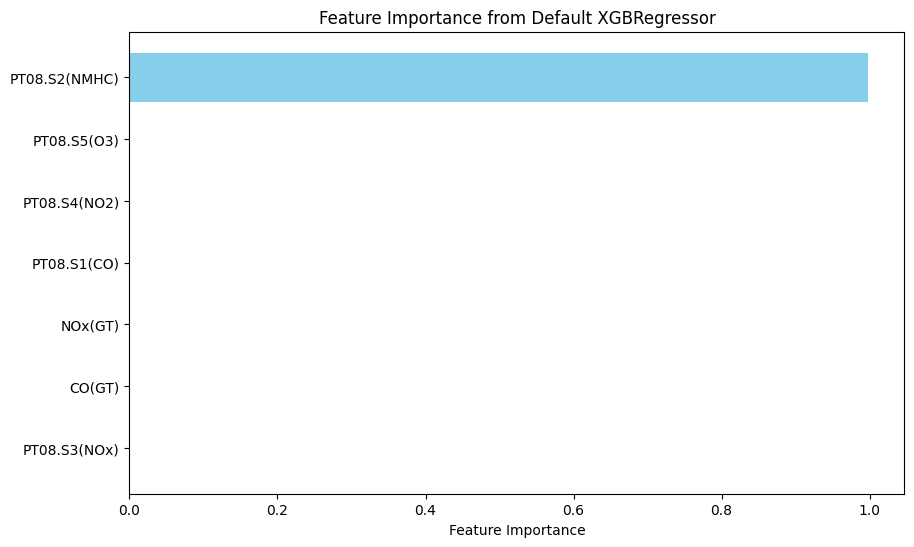

In [ ]:

feature_importance = pd.DataFrame({
    'Feature': train_selected_X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Default XGBRegressor')
plt.gca().invert_yaxis()
plt.show()


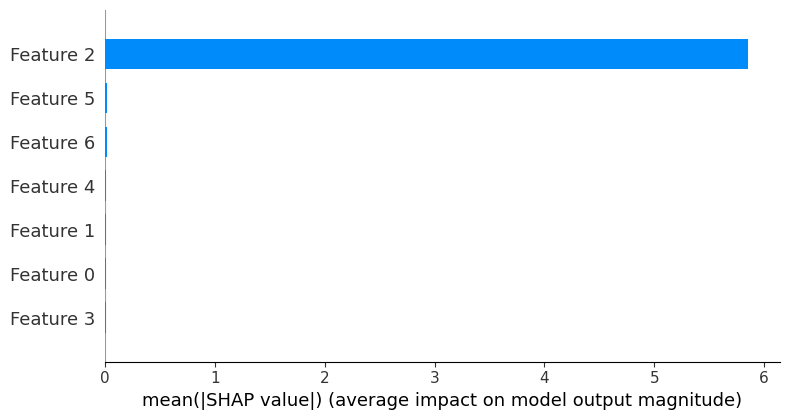

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_scaled[sample_index])



Same as above models

In [ ]:
linear_model = LinearRegression()
y_pred, y_test,X_test_scaled,X_train_scaled,linear_metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,linear_model)

print(linear_metrics)



   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    1.199192  0.974666  1.199192  0.974666   0.832864  1.438062


In [ ]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(train_X)
X_test_poly = poly_features.transform(test_X)

poly_model = LinearRegression()
y_pred, y_test,X_test_scaled,X_train_scaled, poly_metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,poly_model)
print(poly_metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    1.199192  0.974666  1.199192  0.974666   0.832864  1.438062


In [ ]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
y_pred, y_test,X_test_scaled,X_train_scaled, dt_metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,dt_model)
print(dt_metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.356084  0.997766  0.356084  0.997766   0.258936  0.126796


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred, y_test,X_test_scaled,X_train_scaled, rf_metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,rf_model)
print(rf_metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.061752  0.999933  0.061752  0.999933   0.005218  0.003813


In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
y_pred, y_test,X_test_scaled,X_train_scaled, xgb_metrics = train_and_evaluate_model(train_selected_X,train_y,test_selected_X, test_y,xgb_model)
print(xgb_metrics)

   train_RMSE  train_R2  val_RMSE    val_R2  train_MAE   val_MAE
0    0.037221  0.999976  0.037221  0.999976    0.02796  0.001385


In [ ]:
results =[linear_metrics,poly_metrics,dt_metrics,rf_metrics,xgb_metrics]

model_names = ["Linear Regression", "Polynomial Regression", "Decision Tree", "Random Forest", "XGBoost"]

summary_df = pd.concat(results, keys=model_names)
summary_df = summary_df.reset_index(level=0).rename(columns={'level_0': 'Model'})

print(summary_df)


                   Model  train_RMSE  train_R2  val_RMSE    val_R2  train_MAE  \
0      Linear Regression    1.199192  0.974666  1.199192  0.974666   0.832864   
0  Polynomial Regression    1.199192  0.974666  1.199192  0.974666   0.832864   
0          Decision Tree    0.356084  0.997766  0.356084  0.997766   0.258936   
0          Random Forest    0.061752  0.999933  0.061752  0.999933   0.005218   
0                XGBoost    0.037221  0.999976  0.037221  0.999976   0.027960   

    val_MAE  
0  1.438062  
0  1.438062  
0  0.126796  
0  0.003813  
0  0.001385  


<ipython-input-73-1beb0f8c3cd4>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary_df['Model'], rotation=45)
<ipython-input-73-1beb0f8c3cd4>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary_df['Model'], rotation=45)


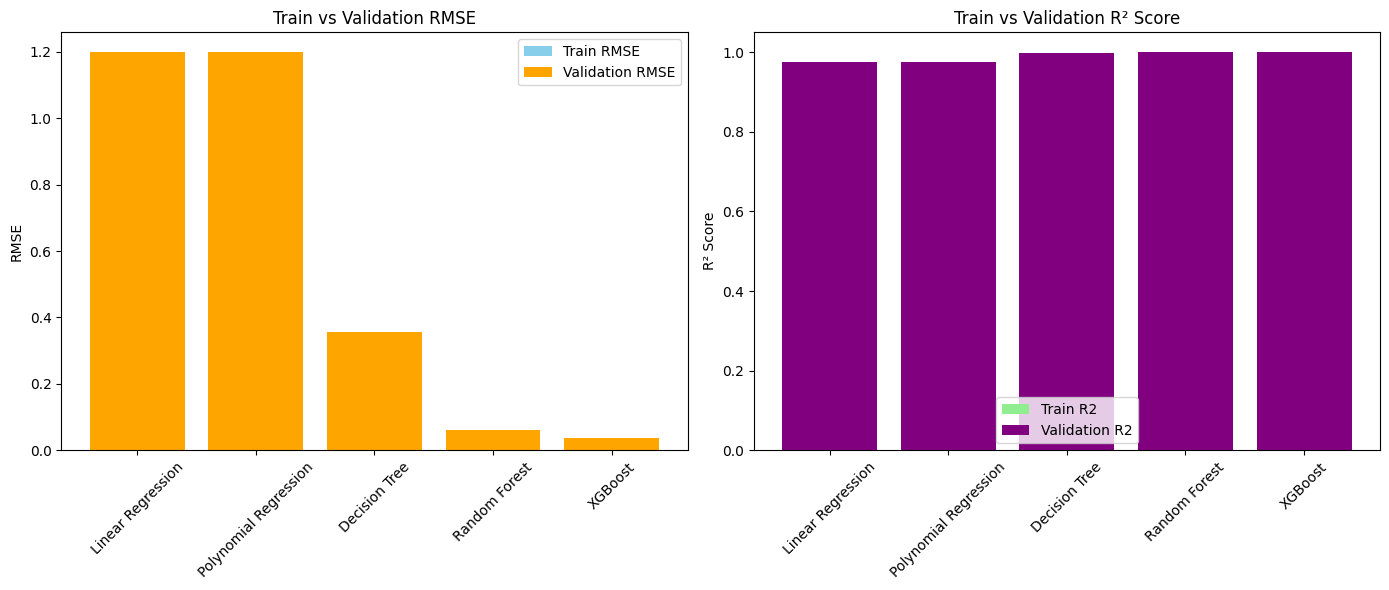

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(summary_df['Model'], summary_df['train_RMSE'], label='Train RMSE', color='skyblue')
axes[0].bar(summary_df['Model'], summary_df['val_RMSE'], label='Validation RMSE', color='orange')
axes[0].set_title('Train vs Validation RMSE')
axes[0].set_ylabel('RMSE')
axes[0].set_xticklabels(summary_df['Model'], rotation=45)
axes[0].legend()

axes[1].bar(summary_df['Model'], summary_df['train_R2'], label='Train R2', color='lightgreen')
axes[1].bar(summary_df['Model'], summary_df['val_R2'], label='Validation R2', color='purple')
axes[1].set_title('Train vs Validation R² Score')
axes[1].set_ylabel('R² Score')
axes[1].set_xticklabels(summary_df['Model'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


Linear and Polynomial Regression:

Both models perform identically with high training and validation RMSE values of 1.199, indicating that they likely underfit the data.

R^2 for both models is approximately 0.975, which suggests decent performance but clearly worse compared to other models.

Decision Tree:

It shows significant improvement over Linear and Polynomial Regression, with train RMSE and validation RMSE of 0.356.

R^2 increases to 0.998, indicating much better model performance.

Random Forest:

This model performs exceptionally well, achieving a very low train RMSE and validation RMSE of 0.062.

𝑅^2 for training and validation is 0.999, showing an excellent fit to the data without noticeable overfitting.

XGBoost:

this model emerges as the best-performing model across all metrics.
It achieves the lowest RMSE (0.037) for both training and validation.

𝑅^2 is extremely close to 1 (0.999976), confirming an almost perfect fit to the data.

The MAE is also the smallest of all models, with 0.028 (train) and 0.001 (validation).



Classificaiton problem

In [ ]:
df = pd.read_csv('weatherAUS.csv')

In [ ]:
print(df.describe())

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.0000

In [ ]:
print(df.isnull().sum())
df.fillna(0, inplace=True)

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [ ]:
# Normalizing numerical columns
scaler = MinMaxScaler()
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'])

<ipython-input-8-a100dca8a33d>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})


In [ ]:
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     22672
           1       0.78      0.25      0.38      6420

    accuracy                           0.82     29092
   macro avg       0.80      0.61      0.63     29092
weighted avg       0.81      0.82      0.78     29092



In [ ]:
param_grid= {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
}


gs = GridSearchCV(
        DecisionTreeClassifier(),
        param_grid,
        n_jobs=-1,
         scoring=['neg_mean_squared_error', 'r2'],
         refit='neg_mean_squared_error',
         cv=tscv
)

NameError: name 'tscv' is not defined

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
best_lr = gs.best_estimator_
y_pred_tuned = best_lr.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_tuned))

Classification report after tuning:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     22672
           1       0.71      0.40      0.51      6420

    accuracy                           0.83     29092
   macro avg       0.78      0.68      0.71     29092
weighted avg       0.82      0.83      0.81     29092



Accuracy is a little bit better.F1 score generally little better.

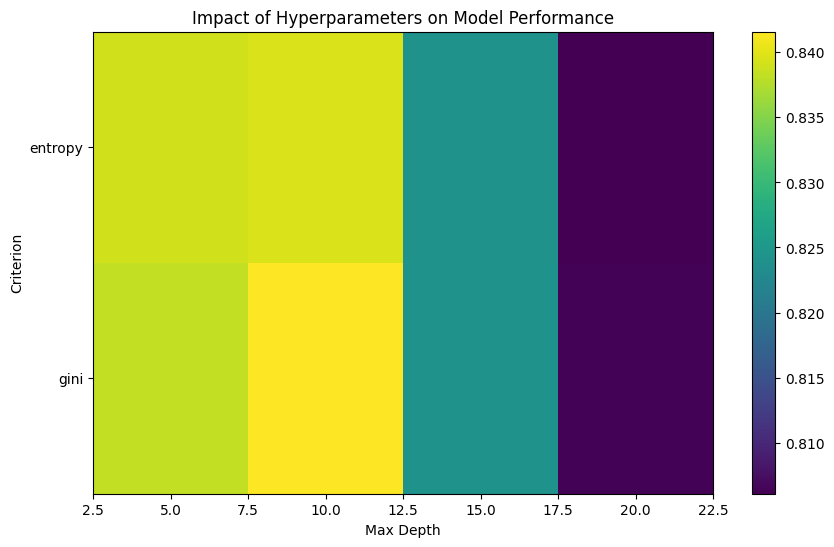

Criterion: gini, Max Depth: 5, Mean Score: 0.8384
Criterion: gini, Max Depth: 10, Mean Score: 0.8416
Criterion: gini, Max Depth: 15, Mean Score: 0.8241
Criterion: gini, Max Depth: 20, Mean Score: 0.8064
Criterion: entropy, Max Depth: 5, Mean Score: 0.8390
Criterion: entropy, Max Depth: 10, Mean Score: 0.8396
Criterion: entropy, Max Depth: 15, Mean Score: 0.8240
Criterion: entropy, Max Depth: 20, Mean Score: 0.8061


In [ ]:

criterion_values = ['gini', 'entropy']
max_depth_values = [ 5, 10, 15, 20]

results = []
for criterion in criterion_values:
    for max_depth in max_depth_values:
        tree_clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=42)
        cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)
        mean_score = np.mean(cv_scores)

        results.append((criterion, max_depth, mean_score))

results_array = np.array(results, dtype=[('criterion', 'U10'),
                                         ('max_depth', 'O'),
                                         ('mean_score', 'f8')])

fig, ax = plt.subplots(figsize=(10, 6))

pivoted_scores = np.zeros((len(criterion_values), len(max_depth_values)))

for i, criterion in enumerate(criterion_values):
    for j, max_depth in enumerate(max_depth_values):
        score = results_array[(results_array['criterion'] == criterion) &
                              (results_array['max_depth'] == max_depth)]['mean_score']
        pivoted_scores[i, j] = score[0]


c = ax.pcolormesh(max_depth_values, criterion_values, pivoted_scores, shading='auto', cmap='viridis')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Criterion')
ax.set_title('Impact of Hyperparameters on Model Performance')

fig.colorbar(c, ax=ax)

plt.show()


for result in results:
    print(f"Criterion: {result[0]}, Max Depth: {result[1]}, Mean Score: {result[2]:.4f}")


The best hyperparameters for this dataset and model are:
Criterion = gini or entropy (both are quite similar)
Max Depth = 10.
These settings result in the highest cross-validation score of 0.8416, suggesting that shallower trees (with max_depth = 10) are preferable to deeper trees in this case. Increasing the depth beyond this point seems to lead to overfitting, reducing the model's performance.

            Feature  Importance
9       Humidity3pm    0.890581
2          Rainfall    0.109419
0           MinTemp    0.000000
76  WindGustDir_SSE    0.000000
88   WindDir9am_NNE    0.000000
87    WindDir9am_NE    0.000000
86     WindDir9am_N    0.000000
85   WindDir9am_ESE    0.000000
84   WindDir9am_ENE    0.000000
83     WindDir9am_E    0.000000


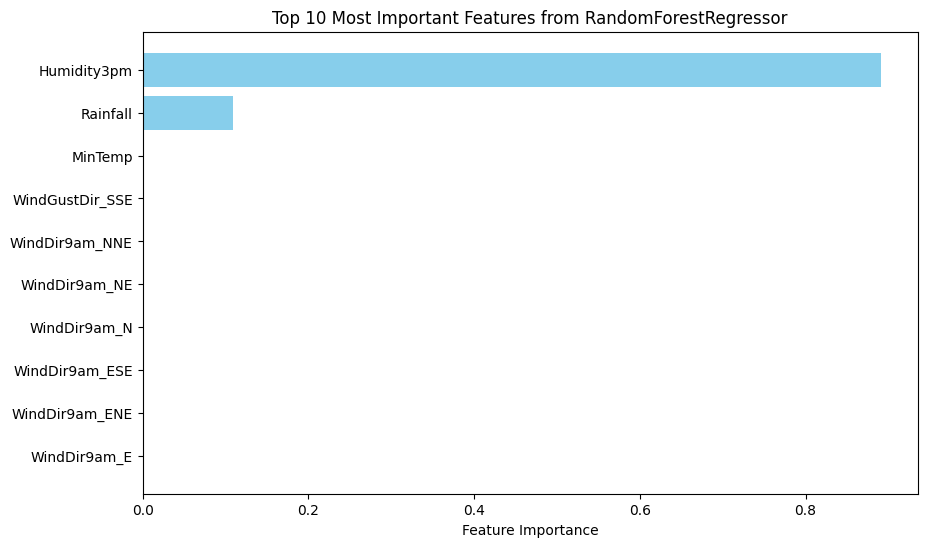

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importance.head(10)
print(top_10_features)


plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features from RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()


The most important feature is Humidity3pm, decision tree model also justifies it.

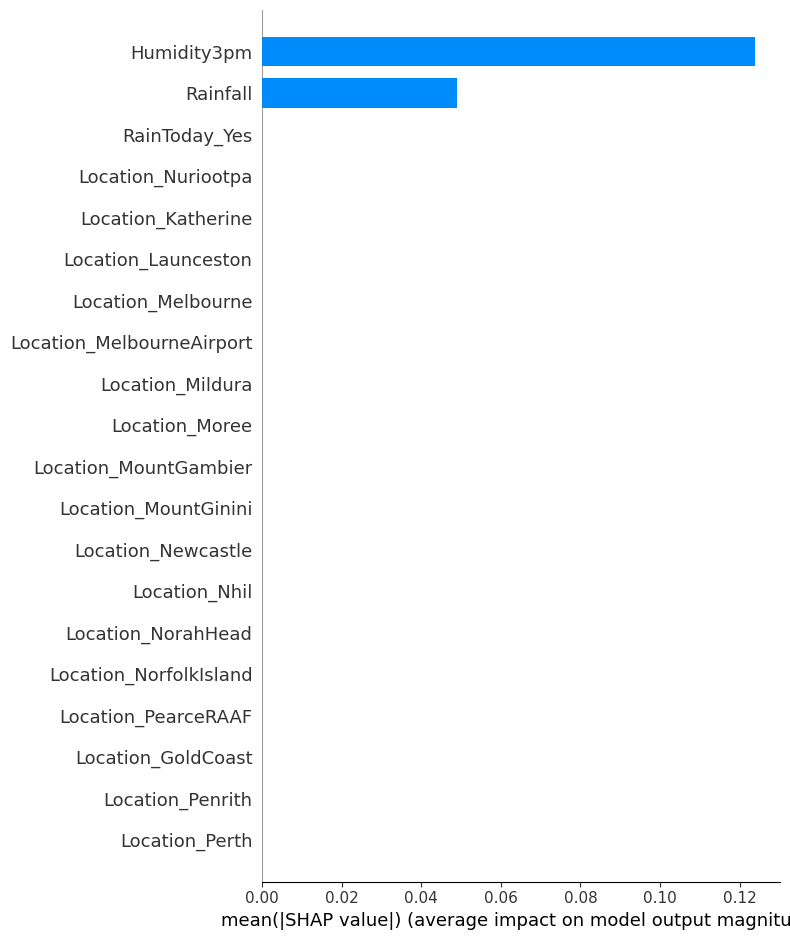

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(tree_reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index])


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

y_pred = forest_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     22672
           1       0.76      0.47      0.58      6420

    accuracy                           0.85     29092
   macro avg       0.81      0.71      0.74     29092
weighted avg       0.84      0.85      0.84     29092



In [ ]:
param_grid= {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10]
}


gs = GridSearchCV(
        RandomForestClassifier(),
        param_grid,
        n_jobs=-1,
        scoring='accuracy',
         cv=tscv
)

In [ ]:
gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
best_lr = gs.best_estimator_
y_pred_tuned = best_lr.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_tuned))

Classification report after tuning:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     22672
           1       0.77      0.47      0.58      6420

    accuracy                           0.85     29092
   macro avg       0.82      0.71      0.75     29092
weighted avg       0.84      0.85      0.84     29092



No difference after hyperparameters tuning.Only little higher macro avg of f1-score

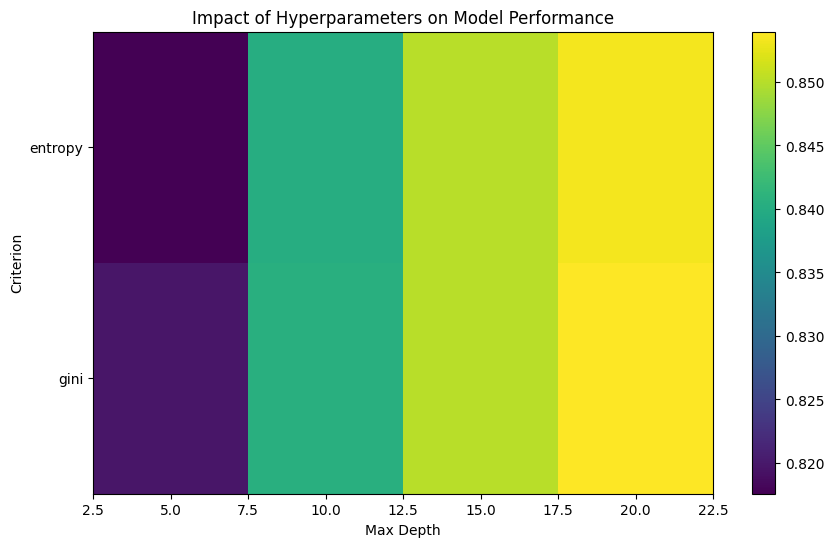

Criterion: gini, Max Depth: 5, Mean Score: 0.8196
Criterion: gini, Max Depth: 10, Mean Score: 0.8405
Criterion: gini, Max Depth: 15, Mean Score: 0.8501
Criterion: gini, Max Depth: 20, Mean Score: 0.8540
Criterion: entropy, Max Depth: 5, Mean Score: 0.8176
Criterion: entropy, Max Depth: 10, Mean Score: 0.8402
Criterion: entropy, Max Depth: 15, Mean Score: 0.8500
Criterion: entropy, Max Depth: 20, Mean Score: 0.8534


In [ ]:

criterion_values = ['gini', 'entropy']
max_depth_values = [ 5, 10, 15, 20]

results = []
for criterion in criterion_values:
    for max_depth in max_depth_values:
        tree_clf = RandomForestClassifier(criterion=criterion, max_depth=max_depth, random_state=42)
        cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)
        mean_score = np.mean(cv_scores)

        results.append((criterion, max_depth, mean_score))

results_array = np.array(results, dtype=[('criterion', 'U10'),
                                         ('max_depth', 'O'),
                                         ('mean_score', 'f8')])

fig, ax = plt.subplots(figsize=(10, 6))

pivoted_scores = np.zeros((len(criterion_values), len(max_depth_values)))

for i, criterion in enumerate(criterion_values):
    for j, max_depth in enumerate(max_depth_values):
        score = results_array[(results_array['criterion'] == criterion) &
                              (results_array['max_depth'] == max_depth)]['mean_score']
        pivoted_scores[i, j] = score[0]


c = ax.pcolormesh(max_depth_values, criterion_values, pivoted_scores, shading='auto', cmap='viridis')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Criterion')
ax.set_title('Impact of Hyperparameters on Model Performance')

fig.colorbar(c, ax=ax)

plt.show()


for result in results:
    print(f"Criterion: {result[0]}, Max Depth: {result[1]}, Mean Score: {result[2]:.4f}")


To optimize the RandomForestClassifier for this task, it seems that:

max_depth = 20 is a good choice, as it leads to the best performance.
criterion = gini gives a slight advantage over entropy.
However, the differences in performance between gini and entropy are quite small, suggesting that either criterion can be used, but gini might be preferred in this case.

Further optimization could involve adjusting other parameters such as n_estimators, min_samples_split, or min_samples_leaf, but based on these results, increasing tree depth and using the Gini criterion yields the best performance for this particular dataset.








          Feature  Importance
9     Humidity3pm    0.135123
8     Humidity9am    0.052680
11    Pressure3pm    0.051152
5   WindGustSpeed    0.049296
10    Pressure9am    0.047185
2        Rainfall    0.046165
15        Temp3pm    0.046087
0         MinTemp    0.044407
1         MaxTemp    0.043842
14        Temp9am    0.041700
4        Sunshine    0.039747
13       Cloud3pm    0.037295
7    WindSpeed3pm    0.032095
6    WindSpeed9am    0.029332
12       Cloud9am    0.023315


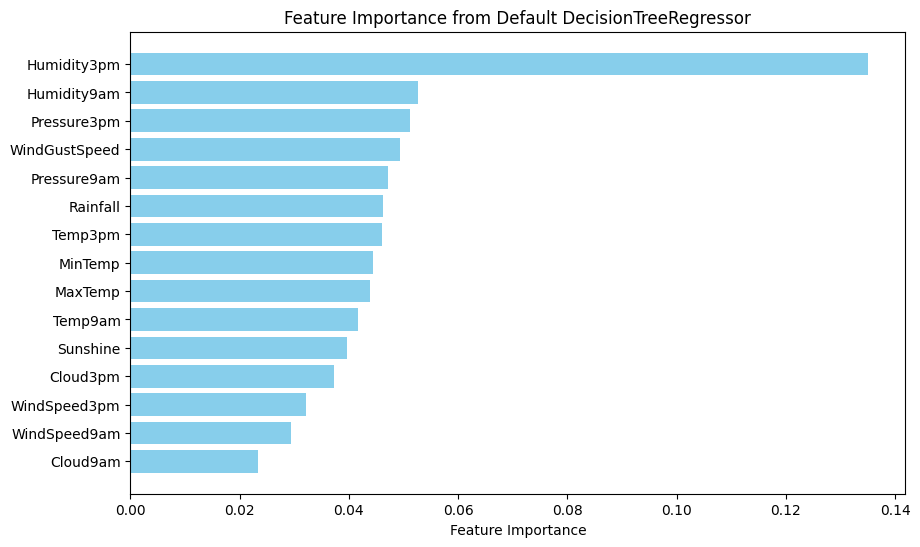

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': forest_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_15_features = feature_importance.head(15)
print(top_15_features)


plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Default DecisionTreeRegressor')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(forest_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test.iloc[sample_index])


In [ ]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

model = xgb.XGBClassifier(scale_pos_weight=sample_weight.mean(), use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train, sample_weight=sample_weight)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:45:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.83      0.88     22672
           1       0.56      0.78      0.66      6420

    accuracy                           0.82     29092
   macro avg       0.75      0.81      0.77     29092
weighted avg       0.85      0.82      0.83     29092



In [ ]:
param_grid= {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
}

gs = GridSearchCV(
        xgb.XGBClassifier(),
        param_grid,
        n_jobs=-1,
         scoring=['neg_mean_squared_error', 'r2'],
         refit='neg_mean_squared_error',
         cv=tscv
)


In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
best_lr = gs.best_estimator_
y_pred_tuned = best_lr.predict(X_test)
print("Classification report after tuning:")
print(classification_report(y_test, y_pred_tuned))


Classification report after tuning:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22672
           1       0.74      0.53      0.62      6420

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



__Result__: Accuracy is better after hyperparameters tuning

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:52:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:52:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:52:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:52:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

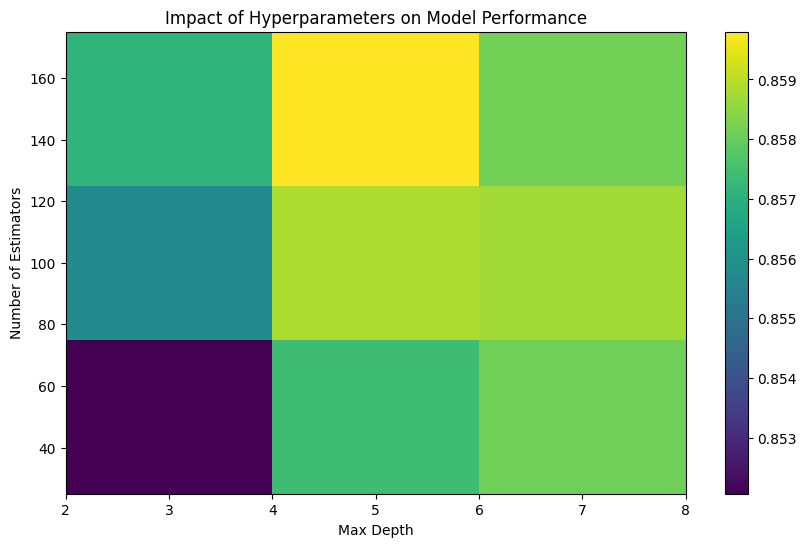

n_estimators: 50, max_depth: 3, Mean Score: 0.8521
n_estimators: 50, max_depth: 5, Mean Score: 0.8574
n_estimators: 50, max_depth: 7, Mean Score: 0.8581
n_estimators: 100, max_depth: 3, Mean Score: 0.8557
n_estimators: 100, max_depth: 5, Mean Score: 0.8589
n_estimators: 100, max_depth: 7, Mean Score: 0.8587
n_estimators: 150, max_depth: 3, Mean Score: 0.8571
n_estimators: 150, max_depth: 5, Mean Score: 0.8598
n_estimators: 150, max_depth: 7, Mean Score: 0.8582


In [ ]:
n_estimators_values = [50, 100, 150]
max_depth_values = [3, 5, 7]

results = []

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        xgb_clf = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, use_label_encoder=False, eval_metric='mlogloss')

        cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)
        mean_score = np.mean(cv_scores)

        results.append((n_estimators, max_depth, mean_score))

results_array = np.array(results, dtype=[('n_estimators', 'i4'),
                                         ('max_depth', 'i4'),
                                         ('mean_score', 'f8')])

fig, ax = plt.subplots(figsize=(10, 6))

pivoted_scores = np.zeros((len(n_estimators_values), len(max_depth_values)))

for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        score = results_array[(results_array['n_estimators'] == n_estimators) &
                              (results_array['max_depth'] == max_depth)]['mean_score']
        pivoted_scores[i, j] = score[0]

c = ax.pcolormesh(max_depth_values, n_estimators_values, pivoted_scores, shading='auto', cmap='viridis')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Number of Estimators')
ax.set_title('Impact of Hyperparameters on Model Performance')

fig.colorbar(c, ax=ax)

plt.show()

for result in results:
    print(f"n_estimators: {result[0]}, max_depth: {result[1]}, Mean Score: {result[2]:.4f}")

A larger number of estimators (100 or 150) leads to better results than a smaller number of estimators (50), but once 150 estimators are reached, further increasing the number does not provide much benefit.
Deeper trees (e.g. max_depth = 7) do not significantly improve performance compared to medium depth values ​​(e.g. max_depth = 5), so shallow trees are sufficient in this case.
It seems that the optimal solution for this task will be n_estimators = 150 and max_depth = 5, because this configuration gives the best result and performance stability.

                  Feature  Importance
9             Humidity3pm    0.080093
117          RainToday_No    0.040691
13               Cloud3pm    0.023617
5           WindGustSpeed    0.021413
2                Rainfall    0.019865
4                Sunshine    0.019262
65          WindGustDir_0    0.018991
16      Location_Adelaide    0.017913
11            Pressure3pm    0.017237
21      Location_Ballarat    0.015785
17        Location_Albany    0.013859
63    Location_Wollongong    0.013729
39   Location_MountGinini    0.013650
55    Location_Townsville    0.013527
103          WindDir3pm_N    0.012579
53        Location_Sydney    0.012550
23      Location_Brisbane    0.012141
56   Location_Tuggeranong    0.012073
86           WindDir9am_N    0.011985
106        WindDir3pm_NNW    0.011385


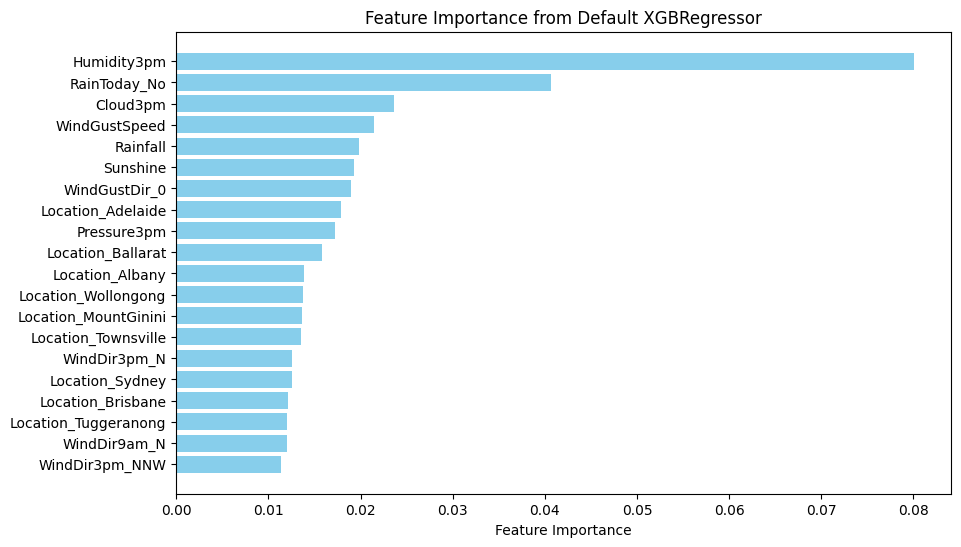

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
top_20_features = feature_importance.head(20)
print(top_20_features)

plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Default XGBRegressor')
plt.gca().invert_yaxis()
plt.show()


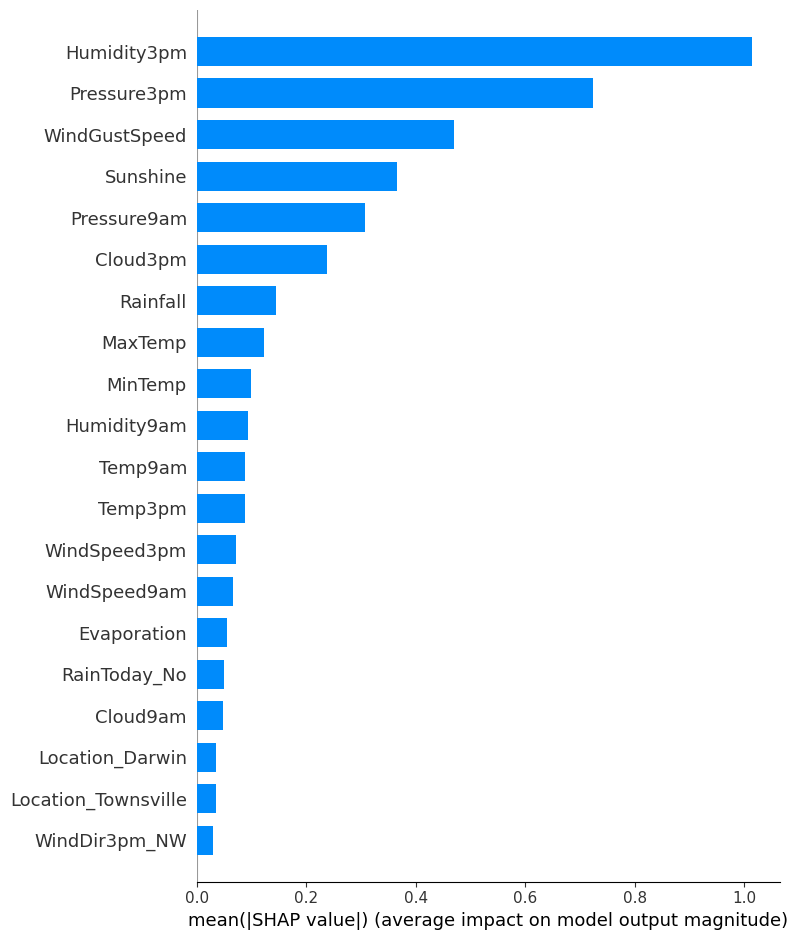

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier (XGBoost/LightGBM)': GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 80)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22672
           1       0.72      0.47      0.57      6420

    accuracy                           0.84     29092
   macro avg       0.79      0.71      0.74     29092
weighted avg       0.83      0.84      0.83     29092

--------------------------------------------------------------------------------
Classification Report for K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     22672
           1       0.60      0.38      0.47      6420

    accuracy                           0.81     29092
   macro avg       0.72      0.66      0.68     29092
weighted avg       0.79      0.81      0.79     29092

--------------------------------------------------------------------------------
Classification Report for Naive Bayes:
              precision    recall  f1-score  

Logistic Regression : Performs well for both classes.

K-Nearest Neighbors (KNN) : Struggles with recall for Class 1, performs well for majority class.

Naive Bayes : High recall for Class 1 but very low precision, poor accuracy overall.

SVM : High accuracy with better precision but struggles with minority recall.
Decision Tree: Balanced but lower performance overall compared to other models.

Random Forest : Robust, but recall for Class 1 remains low despite high accuracy.

Gradient Boosting: Performs comparably to Random Forest, strong overall accuracy.

Best Overall Performance: Random Forest and XGBoost achieve the highest accuracy (85%) with balanced metrics for both classes. They are ideal candidates for this classification problem.

Best Recall for Minority Class: Naive Bayes achieves the highest recall (0.70) for Class 1 but sacrifices precision, leading to a lower F1-score.

Most Interpretable Model: Logistic Regression balances performance and interpretability. It performs well with high accuracy (84%) and reasonable metrics for both classes.